In [8]:
import os   # 导入os模块，用于处理文件路径
import sys  # 导入sys模块，用于修改Python的搜索路径
sys.path.insert(0, "/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties")  # 插入到索引0，确保导入时优先查找父目录

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader  
from torch_geometric.nn import global_mean_pool, global_add_pool  
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from GATModel import GAT
from GCNModel import GCN
from MLPModel import MLP

In [10]:
# 调用样式文件
plt.style.use("../style.mplstyle")

In [11]:
# 固定随机种子
def set_seed(seed):
    import random
    random.seed(seed)  # 固定 Python 的随机种子
    np.random.seed(seed)  # 固定 NumPy 的随机种子
    torch.manual_seed(seed)  # 固定 PyTorch 的随机种子
    torch.cuda.manual_seed(seed)  # 固定 GPU 上的随机种子
    torch.backends.cudnn.deterministic = True  # 确保 CuDNN 的确定性
    torch.backends.cudnn.benchmark = False  # 禁用非确定性算法优化

# 在函数开头调用
set_seed(42)  # 42 是种子值，可替换为其他数值

In [12]:
import torch
# 加载数据集
def load_data_list(file_path):
    """
    从指定文件路径加载数据列表。

    参数：
    file_path (str): 数据列表文件的路径。

    返回：
    list: 加载的数据列表。
    """
    return torch.load(file_path)

############## Tm ##############
Tm_load_file_path = '../dataset/Tm_data_list.pt' # 总数据集
Tm_load_train_dataset_path = '../dataset/train_Tm_data_list.pt' # 训练集
Tm_load_val_dataset_path = '../dataset/val_Tm_data_list.pt' # 验证集
Tm_load_test_dataset_path = '../dataset/test_Tm_data_list.pt' # 验证集

# 加载数据集
Tm_loaded_data_list = load_data_list(Tm_load_file_path)
Tm_loaded_train_data_list = load_data_list(Tm_load_train_dataset_path)
Tm_loaded_val_data_list = load_data_list(Tm_load_val_dataset_path)
Tm_loaded_test_data_list = load_data_list(Tm_load_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(Tm_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(Tm_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(Tm_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(Tm_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
Tm_train_loader = DataLoader(Tm_loaded_train_data_list, batch_size=32, shuffle=True)  
Tm_val_loader = DataLoader(Tm_loaded_val_data_list, batch_size=32, shuffle=False)  
Tm_test_loader = DataLoader(Tm_loaded_test_data_list, batch_size=32, shuffle=False) 


############## conductivity ##############
conductivity_load_file_path = '../dataset/conductivity_data_list.pt' # 总数据集
conductivity_load_train_dataset_path = '../dataset/train_conductivity_data_list.pt' # 训练集
conductivity_load_val_dataset_path = '../dataset/val_conductivity_data_list.pt' # 验证集
conductivity_load_test_dataset_path = '../dataset/test_conductivity_data_list.pt' # 验证集

# 加载数据集
conductivity_loaded_data_list = load_data_list(conductivity_load_file_path)
conductivity_loaded_train_data_list = load_data_list(conductivity_load_train_dataset_path)
conductivity_loaded_val_data_list = load_data_list(conductivity_load_val_dataset_path)
conductivity_loaded_test_data_list = load_data_list(conductivity_load_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(conductivity_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(conductivity_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(conductivity_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(conductivity_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
conductivity_train_loader = DataLoader(conductivity_loaded_train_data_list, batch_size=32, shuffle=True)  
conductivity_val_loader = DataLoader(conductivity_loaded_val_data_list, batch_size=32, shuffle=False)  
conductivity_test_loader = DataLoader(conductivity_loaded_test_data_list, batch_size=32, shuffle=False)  

######################阴离子氧化势######################
anion_ox_save_total_dataset_path = '../dataset/anion_ox_data_list.pt' # 总数据集
anion_ox_save_train_dataset_path = '../dataset/train_anion_ox_data_list.pt' # 训练集
anion_ox_save_val_dataset_path = '../dataset/val_anion_ox_data_list.pt' # 验证集
anion_ox_save_test_dataset_path = '../dataset/test_anion_ox_data_list.pt' # 测试集

# 加载数据集
anion_ox_loaded_data_list = load_data_list(anion_ox_save_total_dataset_path)
anion_ox_loaded_train_data_list = load_data_list(anion_ox_save_train_dataset_path)
anion_ox_loaded_val_data_list = load_data_list(anion_ox_save_val_dataset_path)
anion_ox_loaded_test_data_list = load_data_list(anion_ox_save_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(anion_ox_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(anion_ox_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(anion_ox_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(anion_ox_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
anion_ox_train_loader = DataLoader(anion_ox_loaded_train_data_list, batch_size=32, shuffle=True)  
anion_ox_val_loader = DataLoader(anion_ox_loaded_val_data_list, batch_size=32, shuffle=False)  
anion_ox_test_loader = DataLoader(anion_ox_loaded_test_data_list, batch_size=32, shuffle=False)  

######################阳离子还原势######################
cation_red_save_total_dataset_path = '../dataset/cation_red_data_list.pt' # 总数据集
cation_red_save_train_dataset_path = '../dataset/train_cation_red_data_list.pt' # 训练集
cation_red_save_val_dataset_path = '../dataset/val_cation_red_data_list.pt' # 验证集
cation_red_save_test_dataset_path = '../dataset/test_cation_red_data_list.pt' # 测试集

# 加载数据集
cation_red_loaded_data_list = load_data_list(cation_red_save_total_dataset_path)
cation_red_loaded_train_data_list = load_data_list(cation_red_save_train_dataset_path)
cation_red_loaded_val_data_list = load_data_list(cation_red_save_val_dataset_path)
cation_red_loaded_test_data_list = load_data_list(cation_red_save_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(cation_red_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(cation_red_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(cation_red_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(cation_red_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
cation_red_train_loader = DataLoader(cation_red_loaded_train_data_list, batch_size=32, shuffle=True)  
cation_red_val_loader = DataLoader(cation_red_loaded_val_data_list, batch_size=32, shuffle=False)  
cation_red_test_loader = DataLoader(cation_red_loaded_test_data_list, batch_size=32, shuffle=False)  
# 加载训练集、测试集与验证集
cation_red_train_loader = DataLoader(cation_red_loaded_train_data_list, batch_size=32, shuffle=True)  
cation_red_val_loader = DataLoader(cation_red_loaded_val_data_list, batch_size=32, shuffle=False)  
cation_red_test_loader = DataLoader(cation_red_loaded_test_data_list, batch_size=32, shuffle=False)  

######################离子液体ECW######################
IL_ECW_save_total_dataset_path = '../dataset/IL_ECW_data_list.pt' # 总数据集
IL_ECW_save_train_dataset_path = '../dataset/train_IL_ECW_data_list.pt' # 训练集
IL_ECW_save_val_dataset_path = '../dataset/val_IL_ECW_data_list.pt' # 验证集
IL_ECW_save_test_dataset_path = '../dataset/test_IL_ECW_data_list.pt' # 测试集

# 加载数据集
IL_ECW_loaded_data_list = load_data_list(IL_ECW_save_total_dataset_path)
IL_ECW_loaded_train_data_list = load_data_list(IL_ECW_save_train_dataset_path)
IL_ECW_loaded_val_data_list = load_data_list(IL_ECW_save_val_dataset_path)
IL_ECW_loaded_test_data_list = load_data_list(IL_ECW_save_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(IL_ECW_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(IL_ECW_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(IL_ECW_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(IL_ECW_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
IL_ECW_train_loader = DataLoader(IL_ECW_loaded_train_data_list, batch_size=32, shuffle=True)  
IL_ECW_val_loader = DataLoader(IL_ECW_loaded_val_data_list, batch_size=32, shuffle=False)  
IL_ECW_test_loader = DataLoader(IL_ECW_loaded_test_data_list, batch_size=32, shuffle=False)  

加载的数据列表大小: 1668
加载的训练数据列表大小: 1334
加载的验证数据列表大小: 167
加载的测试数据列表大小: 167
加载的数据列表大小: 549
加载的训练数据列表大小: 439
加载的验证数据列表大小: 55
加载的测试数据列表大小: 55
加载的数据列表大小: 159
加载的训练数据列表大小: 127
加载的验证数据列表大小: 16
加载的测试数据列表大小: 16
加载的数据列表大小: 696
加载的训练数据列表大小: 556
加载的验证数据列表大小: 70
加载的测试数据列表大小: 70
加载的数据列表大小: 1466
加载的训练数据列表大小: 1172
加载的验证数据列表大小: 147
加载的测试数据列表大小: 147


In [13]:
cation_red_loaded_train_data_list[4]

Data(x=[28, 5], edge_index=[2, 58], y=[1, 1], idx=[1], name='Cationname227', smiles='[H]c1n[n+](C([H])([H])C([H])([H])Oc2c([H])c([H])c([H])c([H])c2[H])c([H])c([H])c1[H]', morgan_fp=[1, 2048], moldescriptor=[1, 183])

In [14]:
# 计算模型参数量
def count_parameters(model):
    """
    计算模型的总参数量。
    参数:
        model: PyTorch 模型
    返回:
        total_params: 模型的总参数量
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [27]:
import torch
import torch.nn.functional as F
import numpy as np
import math

# 设置设备为GPU（如果可用），否则使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def training(index, loader, model, loss_fn, optimizer, scale=1):
    """
    训练函数，对模型进行一个epoch的训练。

    参数：
    - loader: DataLoader对象，训练数据加载器
    - model: 待训练的模型
    - loss_fn: 损失函数
    - optimizer: 优化器

    返回：
    - average_loss: 当前epoch的平均损失
    """
    model.train()  # 设置模型为训练模式
    total_loss = 0  # 初始化总损失
    
    for data in loader:  # 遍历每个批次的数据
        data = data.to(device)  # 将数据移动到GPU
        optimizer.zero_grad()  # 清空梯度
        data.x = data.x.float()  # 将节点特征转换为浮点数
        out = model(data)  # 前向传播计算输出
        loss = loss_fn(out, scale*data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数
        total_loss += loss.item()  # 累加损失值
        
    average_loss = total_loss / len(loader)  # 计算平均损失

    
    return average_loss  # 返回当前epoch的平均损失

def validation(index, loader, model, loss_fn, scale=1):
    """
    验证函数，评估模型在验证集上的性能。

    参数：
    - loader: DataLoader对象，验证数据加载器
    - model: 待评估的模型
    - loss_fn: 损失函数

    返回：
    - average_loss: 验证集上的平均损失
    """
    model.eval()  # 设置模型为评估模式
    total_loss = 0  # 初始化总损失
    
    with torch.no_grad():  # 禁用梯度计算，节省内存
        for data in loader:  # 遍历验证集中的每个批次
            data = data.to(device)  # 将数据移动到GPU
            data.x = data.x.float()  # 将节点特征转换为浮点数
            out = model(data)  # 前向传播计算输出
            loss = loss_fn(out, scale*data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
            total_loss += loss.item()  # 累加损失值
            
    average_loss = total_loss / len(loader)  # 计算平均损失
    
    return average_loss  # 返回验证集的平均损失

def train_epochs(index, epochs, model, train_loader, val_loader, test_loader, path, scale=1):
    """
    训练多个epoch的函数，并在每个epoch后进行验证。

    参数：
    - epochs: 总的训练epoch数
    - model: 待训练的模型
    - train_loader: DataLoader对象，训练数据加载器
    - val_loader: DataLoader对象，验证数据加载器
    - path: 保存最佳模型的路径

    返回：
    - train_losses: 包含每个epoch训练损失的数组
    - val_losses: 包含每个epoch验证损失的数组
    - train_pred: 最后一个epoch的训练集预测值数组
    - train_true: 最后一个epoch的训练集真实值数组
    """
    # 定义初始学习率
    initial_lr = 5e-4

    optimizer = torch.optim.Adam(model.parameters(), initial_lr, weight_decay=5e-4)  # 定义优化器
    loss_fn = torch.nn.MSELoss()  # 定义均方误差损失函数

    train_losses = np.zeros(epochs)  # 初始化存储每个epoch训练损失的数组
    val_losses = np.zeros(epochs)  # 初始化存储每个epoch验证损失的数组
    best_loss = float('inf')  # 初始化最佳验证损失为正无穷

    patience_counter = 0        # 初始化早停计数器
    max_patience = epochs/10           # 设置连续没有改进的最大轮数为epochs/10

    # 当前学习率变量，便于后续动态调整
    current_lr = initial_lr

    for epoch in range(epochs):
        # 训练一个epoch并获取平均训练损失
        train_loss = training(index, train_loader, model, loss_fn, optimizer, scale)
        # 验证当前模型并获取平均验证损失
        val_loss = validation(index, val_loader, model, loss_fn, scale)
        
        # 记录当前epoch的训练和验证损失
        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss

        # 打印当前epoch的损失情况
        print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

        # 检查验证损失是否得到改善
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), path)  # 保存当前最佳模型
            print("Model has been saved!")
            # 改进时重置早停计数器
            patience_counter = 0
        else:
            # 若无改善，早停计数器加1
            patience_counter += 1
            print(f"Patience counter: {patience_counter}")
            # 检查是否达到连续无改进的最大轮数
            if patience_counter >= max_patience:
                # 判断当前学习率是否还可以降低
                if current_lr > initial_lr / 1000:
                    # 降低学习率为原来的1/10
                    current_lr /= 10
                    # 更新优化器中每个参数组的学习率
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = current_lr
                    print(f"Learning rate reduced to: {current_lr}")
                    # 降低学习率后重置早停计数器，继续训练
                    patience_counter = 0
                else:
                    # 当学习率已经降至初始学习率的1/1000且仍无改进时，触发提前停止
                    print(f"Early stopping triggered. Learning rate has reached its minimum threshold ({current_lr}).")
                    break

    # 在测试集上对模型进行评估
    model.load_state_dict(torch.load(path)) # 加载训练结束后最好的模型
    model.to(device)
    model.eval()

    total_loss = 0
    test_pred = []
    test_true = []
    loss_fn = torch.nn.MSELoss()  # 定义均方误差损失函数

    # 在测试集上进行评估
    for data in test_loader:
        data = data.to(device)
        data.x = data.x.float()
        out = model(data)
        loss = loss_fn(out, scale*data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
        total_loss += loss.item()
        # 模型输出的预测值已经是在放大后的尺度上
        test_pred.append(out.detach().cpu().numpy())
        test_true.append(scale*data.y.cpu().numpy())

    test_pred = np.concatenate(test_pred, axis=0)
    test_true = np.concatenate(test_true, axis=0)
    average_loss = total_loss / len(test_loader)

    # 计算测试集上的指标：MSE, MAE 和 R2
    test_pred_flat = test_pred.flatten()  # 扁平化预测结果
    test_true_flat = test_true.flatten()  # 扁平化真实值
    test_mse = mean_squared_error(test_true_flat, test_pred_flat)
    test_mae = mean_absolute_error(test_true_flat, test_pred_flat)
    test_r2 = r2_score(test_true_flat, test_pred_flat)

    print(f"Test Loss: {average_loss:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    
    return train_losses, val_losses, test_pred, test_true, test_mse, test_mae, test_r2  # 返回损失和预测结果



In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import math

# 设置设备为GPU（如果可用），否则使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def training_mlp(index, loader, model, loss_fn, optimizer, scale=10, input_type="fp"):
    """
    训练函数，对模型进行一个epoch的训练。

    参数：
    - loader: DataLoader对象，训练数据加载器
    - model: 待训练的模型
    - loss_fn: 损失函数
    - optimizer: 优化器
    - input_type: 可选"fp"（分子指纹）或者“2Ddescriptors”
    返回：
    - average_loss: 当前epoch的平均损失
    """
    model.train()  # 设置模型为训练模式
    total_loss = 0  # 初始化总损失
    for data in loader:  # 遍历每个批次的数据
        data = data.to(device)  # 将数据移动到GPU
        optimizer.zero_grad()  # 清空梯度
        
        if input_type=="fp":
            data.morgan_fp = data.morgan_fp.float()  # 将节点特征转换为浮点数
        elif input_type=="2Ddescriptors":
            data.moldescriptor = data.moldescriptor.float()  # 将节点特征转换为浮点数
            
        out = model(data)  # 前向传播计算输出
        loss = loss_fn(out, scale*data.y.view(-1, 1))  # 只取 y 的最后一列作为真值，由于单位转化为ms/cm，所以y值需要乘以10
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数
        total_loss += loss.item()  # 累加损失值
    average_loss = total_loss / len(loader)  # 计算平均损失
    return average_loss  # 返回当前epoch的平均损失

def validation_mlp(index, loader, model, loss_fn, scale=10, input_type="fp"):
    """
    验证函数，评估模型在验证集上的性能。

    参数：
    - loader: DataLoader对象，验证数据加载器
    - model: 待评估的模型
    - loss_fn: 损失函数

    返回：
    - average_loss: 验证集上的平均损失
    """
    model.eval()  # 设置模型为评估模式
    total_loss = 0  # 初始化总损失
    with torch.no_grad():  # 禁用梯度计算，节省内存
        for data in loader:  # 遍历验证集中的每个批次
            data = data.to(device)  # 将数据移动到GPU
            
            if input_type=="fp":
                data.morgan_fp = data.morgan_fp.float()  # 将节点特征转换为浮点数
            elif input_type=="2Ddescriptors":
                data.moldescriptor = data.moldescriptor.float()  # 将节点特征转换为浮点数

            out = model(data)  # 前向传播计算输出
            loss = loss_fn(out, scale*data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
            total_loss += loss.item()  # 累加损失值
    average_loss = total_loss / len(loader)  # 计算平均损失
    return average_loss  # 返回验证集的平均损失

def train_epochs_mlp(index, epochs, model, train_loader, val_loader, test_loader, path, scale=10, input_type="fp"):
    """
    训练多个epoch的函数，并在每个epoch后进行验证。

    参数：
    - epochs: 总的训练epoch数
    - model: 待训练的模型
    - train_loader: DataLoader对象，训练数据加载器
    - val_loader: DataLoader对象，验证数据加载器
    - path: 保存最佳模型的路径

    返回：
    - train_losses: 包含每个epoch训练损失的数组
    - val_losses: 包含每个epoch验证损失的数组
    - train_pred: 最后一个epoch的训练集预测值数组
    - train_true: 最后一个epoch的训练集真实值数组
    """
    initial_lr = 5e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=5e-4)  # 定义优化器
    loss_fn = torch.nn.MSELoss()  # 定义均方误差损失函数

    train_losses = np.zeros(epochs)  # 初始化存储每个epoch训练损失的数组
    val_losses = np.zeros(epochs)  # 初始化存储每个epoch验证损失的数组
    best_loss = float('inf')  # 初始化最佳验证损失为正无穷

    patience_counter = 0        # 初始化早停计数器
    max_patience = epochs/10           # 设置连续没有改进的最大轮数为epochs/20
    # 当前学习率变量，便于后续动态调整
    current_lr = initial_lr

    for epoch in range(epochs):
        # 训练一个epoch并获取平均训练损失
        train_loss = training_mlp(index, train_loader, model, loss_fn, optimizer, scale, input_type="fp")
        # 验证当前模型并获取平均验证损失
        val_loss = validation_mlp(index, val_loader, model, loss_fn, scale, input_type="fp")
        
        # 记录当前epoch的训练和验证损失
        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss

        # 打印当前epoch的损失情况
        print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

        # 检查验证损失是否得到改善
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), path)  # 保存当前最佳模型
            print("Model has been saved!")
            # 改进时重置早停计数器
            patience_counter = 0
        else:
            # 若无改善，早停计数器加1
            patience_counter += 1
            print(f"Patience counter: {patience_counter}")
            # 检查是否达到连续无改进的最大轮数
            if patience_counter >= max_patience:
                # 判断当前学习率是否还可以降低
                if current_lr > initial_lr / 1000:
                    # 降低学习率为原来的1/10
                    current_lr /= 10
                    # 更新优化器中每个参数组的学习率
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = current_lr
                    print(f"Learning rate reduced to: {current_lr}")
                    # 降低学习率后重置早停计数器，继续训练
                    patience_counter = 0
                else:
                    # 当学习率已经降至初始学习率的1/1000且仍无改进时，触发提前停止
                    print(f"Early stopping triggered. Learning rate has reached its minimum threshold ({current_lr}).")
                    break

    # 在测试集上对模型进行评估
    model.load_state_dict(torch.load(path)) # 加载训练结束后最好的模型
    model.to(device)
    model.eval()

    total_loss = 0
    test_pred = []
    test_true = []
    loss_fn = torch.nn.MSELoss()  # 定义均方误差损失函数

    # 在测试集上进行评估
    for data in test_loader:
        data = data.to(device)
        if input_type=="fp":
            data.morgan_fp = data.morgan_fp.float()  # 将节点特征转换为浮点数
        elif input_type=="2Ddescriptors":
            data.moldescriptor = data.moldescriptor.float()  # 将节点特征转换为浮点数
        out = model(data)
        loss = loss_fn(out, scale*data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
        total_loss += loss.item()
        # 模型输出的预测值已经是在放大后的尺度上
        test_pred.append(out.detach().cpu().numpy())
        # 为了保证尺度一致
        test_true.append(scale*data.y.cpu().numpy())

    test_pred = np.concatenate(test_pred, axis=0)
    test_true = np.concatenate(test_true, axis=0)
    average_loss = total_loss / len(test_loader)

    # 计算测试集上的指标：MSE, MAE 和 R2
    test_pred_flat = test_pred.flatten()  # 扁平化预测结果
    test_true_flat = test_true.flatten()  # 扁平化真实值
    test_mse = mean_squared_error(test_true_flat, test_pred_flat)
    test_mae = mean_absolute_error(test_true_flat, test_pred_flat)
    test_r2 = r2_score(test_true_flat, test_pred_flat)

    print(f"Test Loss: {average_loss:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    
    return train_losses, val_losses, test_pred, test_true, test_mse, test_mae, test_r2  # 返回损失和预测结果



In [29]:
# GAT
model_Tm_GAT = GAT(in_channels=5,hidden_channels=256).to(device)  
model_conductivity_GAT = GAT(in_channels=5,hidden_channels=256).to(device)  
model_anion_ox_GAT = GAT(in_channels=5,hidden_channels=256).to(device)  
model_cation_red_GAT = GAT(in_channels=5,hidden_channels=256).to(device)  
model_IL_ECW_GAT = GAT(in_channels=5,hidden_channels=256).to(device) 
# GCN
model_Tm_GCN = GCN(hidden_dim=128).to(device)
model_conductivity_GCN = GCN(hidden_dim=128).to(device) 
model_anion_ox_GCN = GCN(hidden_dim=128).to(device) 
model_cation_red_GCN = GCN(hidden_dim=128).to(device) 
model_IL_ECW_GCN = GCN(hidden_dim=128).to(device) 
# MLP
input_size = 2048
hidden_sizes = [256, 64]
output_size = 1
epochs = 200
model_Tm_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_conductivity_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_anion_ox_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_cation_red_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_IL_ECW_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 

# GAT Model

In [ ]:
# 训练模型，设置epoch数为100
epochs = 200

# 熔点GAT模型
Tm_train_losses_gat, Tm_val_losses_gat, Tm_test_pred_gat, Tm_test_true_gat, Tm_test_mse_gat, Tm_test_mae_gat, Tm_test_r2_gat = train_epochs(
    0, epochs, model_Tm_GAT, Tm_train_loader, Tm_val_loader, Tm_test_loader, "Tm_GAT_model.pt"
)

# 电导率GAT模型
conductivity_train_losses_gat, conductivity_val_losses_gat, conductivity_test_pred_gat, conductivity_test_true_gat, conductivity_test_mse_gat, conductivity_test_mae_gat, conductivity_test_r2_gat = train_epochs(
    0, epochs, model_conductivity_GAT, conductivity_train_loader, conductivity_val_loader, conductivity_test_loader, "conductivity_GAT_model.pt", scale=10
)

Epoch: 0, Train loss: 6.3579, Val loss: 4.7279
Model has been saved!
Epoch: 1, Train loss: 5.5067, Val loss: 4.7029
Model has been saved!
Epoch: 2, Train loss: 5.1164, Val loss: 4.7005
Model has been saved!
Epoch: 3, Train loss: 5.4283, Val loss: 4.8492
Patience counter: 1
Epoch: 4, Train loss: 4.8972, Val loss: 4.3962
Model has been saved!
Epoch: 5, Train loss: 5.1182, Val loss: 4.3173
Model has been saved!
Epoch: 6, Train loss: 5.0397, Val loss: 4.2361
Model has been saved!
Epoch: 7, Train loss: 4.7135, Val loss: 4.1502
Model has been saved!
Epoch: 8, Train loss: 4.6985, Val loss: 4.1015
Model has been saved!
Epoch: 9, Train loss: 4.6534, Val loss: 4.1630
Patience counter: 1
Epoch: 10, Train loss: 4.7291, Val loss: 4.0575
Model has been saved!
Epoch: 11, Train loss: 4.7766, Val loss: 4.0638
Patience counter: 1
Epoch: 12, Train loss: 4.3567, Val loss: 3.9738
Model has been saved!
Epoch: 13, Train loss: 4.6638, Val loss: 4.0701
Patience counter: 1
Epoch: 14, Train loss: 4.6076, Val los

In [23]:
# 训练模型，设置epoch数为100
epochs = 200

# 阴离子氧化势GAT模型
anion_ox_train_losses_gat, anion_ox_val_losses_gat, anion_ox_test_pred_gat, anion_ox_test_true_gat, anion_ox_test_mse_gat, anion_ox_test_mae_gat, anion_ox_test_r2_gat = train_epochs(
    0, epochs, model_anion_ox_GAT, anion_ox_train_loader, anion_ox_val_loader, anion_ox_test_loader, "anion_ox_GAT_model.pt"
)

# 阳离子还原势GAT模型
cation_red_train_losses_gat, cation_red_val_losses_gat, cation_red_test_pred_gat, cation_red_test_true_gat, cation_red_test_mse_gat, cation_red_test_mae_gat, cation_red_test_r2_gat = train_epochs(
    0, epochs, model_cation_red_GAT, cation_red_train_loader, cation_red_val_loader, cation_red_test_loader, "cation_red_GAT_model.pt"
)

Epoch: 0, Train loss: 2.7326, Val loss: 2.7854
Model has been saved!
Epoch: 1, Train loss: 2.6732, Val loss: 2.9394
Patience counter: 1
Epoch: 2, Train loss: 2.0669, Val loss: 3.6037
Patience counter: 2
Epoch: 3, Train loss: 1.8777, Val loss: 2.5932
Model has been saved!
Epoch: 4, Train loss: 2.0786, Val loss: 2.7414
Patience counter: 1
Epoch: 5, Train loss: 1.9872, Val loss: 3.0885
Patience counter: 2
Epoch: 6, Train loss: 1.8031, Val loss: 2.7540
Patience counter: 3
Epoch: 7, Train loss: 1.8491, Val loss: 2.6854
Patience counter: 4
Epoch: 8, Train loss: 2.0075, Val loss: 2.7890
Patience counter: 5
Epoch: 9, Train loss: 1.8161, Val loss: 2.9009
Patience counter: 6
Epoch: 10, Train loss: 1.7761, Val loss: 2.7897
Patience counter: 7
Epoch: 11, Train loss: 1.9610, Val loss: 2.8464
Patience counter: 8
Epoch: 12, Train loss: 1.7389, Val loss: 2.6493
Patience counter: 9
Epoch: 13, Train loss: 1.9751, Val loss: 2.8676
Patience counter: 10
Epoch: 14, Train loss: 1.8205, Val loss: 2.8600
Patie

In [24]:
# 训练模型，设置epoch数为100
epochs = 200

# 阳离子还原势GAT模型
IL_ECW_train_losses_gat, IL_ECW_val_losses_gat, IL_ECW_test_pred_gat, IL_ECW_test_true_gat, IL_ECW_test_mse_gat, IL_ECW_test_mae_gat, IL_ECW_test_r2_gat = train_epochs(
    0, epochs, model_IL_ECW_GAT, IL_ECW_train_loader, IL_ECW_val_loader, IL_ECW_test_loader, "IL_ECW_GAT_model.pt"
)

Epoch: 0, Train loss: 3.7250, Val loss: 3.4247
Model has been saved!
Epoch: 1, Train loss: 3.2735, Val loss: 3.2925
Model has been saved!
Epoch: 2, Train loss: 3.2506, Val loss: 3.3717
Patience counter: 1
Epoch: 3, Train loss: 3.0221, Val loss: 3.0153
Model has been saved!
Epoch: 4, Train loss: 2.9660, Val loss: 2.9578
Model has been saved!
Epoch: 5, Train loss: 2.8422, Val loss: 2.9067
Model has been saved!
Epoch: 6, Train loss: 2.6589, Val loss: 2.7863
Model has been saved!
Epoch: 7, Train loss: 2.4904, Val loss: 2.9605
Patience counter: 1
Epoch: 8, Train loss: 2.3865, Val loss: 2.7215
Model has been saved!
Epoch: 9, Train loss: 2.6620, Val loss: 3.7904
Patience counter: 1
Epoch: 10, Train loss: 2.5029, Val loss: 2.6549
Model has been saved!
Epoch: 11, Train loss: 2.3963, Val loss: 2.6610
Patience counter: 1
Epoch: 12, Train loss: 2.3747, Val loss: 2.6366
Model has been saved!
Epoch: 13, Train loss: 2.2906, Val loss: 2.5441
Model has been saved!
Epoch: 14, Train loss: 2.2641, Val los

# GCN Model

In [ ]:
# 训练模型，设置epoch数为100
epochs = 200

# 熔点GCN模型
Tm_train_losses_gcn, Tm_val_losses_gcn, Tm_test_pred_gcn, Tm_test_true_gcn, Tm_test_mse_gcn, Tm_test_mae_gcn, Tm_test_r2_gcn = train_epochs(
    0, epochs, model_Tm_GCN, Tm_train_loader, Tm_val_loader, Tm_test_loader, "Tm_GCN_model.pt"
)

# 电导率GCN模型
conductivity_train_losses_gcn, conductivity_val_losses_gcn, conductivity_test_pred_gcn, conductivity_test_true_gcn, conductivity_test_mse_gcn, conductivity_test_mae_gcn, conductivity_test_r2_gcn = train_epochs(
    0, epochs, model_conductivity_GCN, conductivity_train_loader, conductivity_val_loader, conductivity_test_loader, "conductivity_GCN_model.pt", scale=10
)

Epoch: 0, Train loss: 6.2317, Val loss: 5.9087
Model has been saved!
Epoch: 1, Train loss: 5.7853, Val loss: 5.0352
Model has been saved!
Epoch: 2, Train loss: 5.1652, Val loss: 4.2417
Model has been saved!
Epoch: 3, Train loss: 5.0685, Val loss: 4.1457
Model has been saved!
Epoch: 4, Train loss: 4.8006, Val loss: 4.3940
Patience counter: 1
Epoch: 5, Train loss: 4.4212, Val loss: 3.4913
Model has been saved!
Epoch: 6, Train loss: 4.2824, Val loss: 4.1552
Patience counter: 1
Epoch: 7, Train loss: 4.0612, Val loss: 3.8310
Patience counter: 2
Epoch: 8, Train loss: 4.1228, Val loss: 3.7771
Patience counter: 3
Epoch: 9, Train loss: 4.2387, Val loss: 3.6043
Patience counter: 4
Epoch: 10, Train loss: 3.8354, Val loss: 3.7281
Patience counter: 5
Epoch: 11, Train loss: 3.5981, Val loss: 3.4450
Model has been saved!
Epoch: 12, Train loss: 3.3871, Val loss: 3.6897
Patience counter: 1
Epoch: 13, Train loss: 3.5019, Val loss: 3.6491
Patience counter: 2
Epoch: 14, Train loss: 3.6115, Val loss: 3.677

In [24]:
# 训练模型，设置epoch数为100
epochs = 200

# 阴离子氧化势GAT模型
anion_ox_train_losses_gcn, anion_ox_val_losses_gcn, anion_ox_test_pred_gcn, anion_ox_test_true_gcn, anion_ox_test_mse_gcn, anion_ox_test_mae_gcn, anion_ox_test_r2_gcn = train_epochs(
    0, epochs, model_anion_ox_GCN, anion_ox_train_loader, anion_ox_val_loader, anion_ox_test_loader, "anion_ox_GCN_model.pt"
)

# 阳离子还原势GAT模型
cation_red_train_losses_gcn, cation_red_val_losses_gcn, cation_red_test_pred_gcn, cation_red_test_true_gcn, cation_red_test_mse_gcn, cation_red_test_mae_gcn, cation_red_test_r2_gcn = train_epochs(
    0, epochs, model_cation_red_GCN, cation_red_train_loader, cation_red_val_loader, cation_red_test_loader, "cation_red_GCN_model.pt"
)

Epoch: 0, Train loss: 2.0167, Val loss: 2.8464
Model has been saved!
Epoch: 1, Train loss: 1.6880, Val loss: 2.6999
Model has been saved!
Epoch: 2, Train loss: 1.6647, Val loss: 2.6945
Model has been saved!
Epoch: 3, Train loss: 1.7363, Val loss: 2.7108
Patience counter: 1
Epoch: 4, Train loss: 1.5792, Val loss: 2.6130
Model has been saved!
Epoch: 5, Train loss: 1.6416, Val loss: 2.6269
Patience counter: 1
Epoch: 6, Train loss: 1.3759, Val loss: 2.7134
Patience counter: 2
Epoch: 7, Train loss: 1.6198, Val loss: 2.6950
Patience counter: 3
Epoch: 8, Train loss: 1.9498, Val loss: 2.5693
Model has been saved!
Epoch: 9, Train loss: 1.6771, Val loss: 2.5602
Model has been saved!
Epoch: 10, Train loss: 1.4128, Val loss: 2.6052
Patience counter: 1
Epoch: 11, Train loss: 1.5502, Val loss: 2.6235
Patience counter: 2
Epoch: 12, Train loss: 1.4395, Val loss: 2.5787
Patience counter: 3
Epoch: 13, Train loss: 1.3177, Val loss: 2.5793
Patience counter: 4
Epoch: 14, Train loss: 1.3788, Val loss: 2.693

In [25]:
# 训练模型，设置epoch数为100
epochs = 200

# 阳离子还原势GAT模型
IL_ECW_train_losses_gcn, IL_ECW_val_losses_gcn, IL_ECW_test_pred_gcn, IL_ECW_test_true_gcn, IL_ECW_test_mse_gcn, IL_ECW_test_mae_gcn, IL_ECW_test_r2_gcn = train_epochs(
    0, epochs, model_IL_ECW_GCN, IL_ECW_train_loader, IL_ECW_val_loader, IL_ECW_test_loader, "IL_ECW_GCN_model.pt"
)

Epoch: 0, Train loss: 3.4408, Val loss: 3.3737
Model has been saved!
Epoch: 1, Train loss: 2.2711, Val loss: 1.9721
Model has been saved!
Epoch: 2, Train loss: 2.0327, Val loss: 1.6317
Model has been saved!
Epoch: 3, Train loss: 2.0260, Val loss: 1.9676
Patience counter: 1
Epoch: 4, Train loss: 1.9163, Val loss: 1.3783
Model has been saved!
Epoch: 5, Train loss: 1.9274, Val loss: 2.3452
Patience counter: 1
Epoch: 6, Train loss: 1.7109, Val loss: 1.3619
Model has been saved!
Epoch: 7, Train loss: 1.7435, Val loss: 3.2062
Patience counter: 1
Epoch: 8, Train loss: 1.8608, Val loss: 1.7715
Patience counter: 2
Epoch: 9, Train loss: 1.5867, Val loss: 1.6533
Patience counter: 3
Epoch: 10, Train loss: 1.5599, Val loss: 2.0043
Patience counter: 4
Epoch: 11, Train loss: 1.6765, Val loss: 2.0675
Patience counter: 5
Epoch: 12, Train loss: 1.5098, Val loss: 1.3584
Model has been saved!
Epoch: 13, Train loss: 1.5162, Val loss: 1.7687
Patience counter: 1
Epoch: 14, Train loss: 1.3958, Val loss: 2.137

# MLP Model

In [ ]:
# 训练模型，设置epoch数为100
epochs = 200

# 熔点MLP模型
Tm_train_losses_mlp, Tm_val_losses_mlp, Tm_test_pred_mlp, Tm_test_true_mlp, Tm_test_mse_mlp, Tm_test_mae_mlp, Tm_test_r2_mlp = train_epochs_mlp(
    0, epochs, model_Tm_MLP, Tm_train_loader, Tm_val_loader, Tm_test_loader, "Tm_MLP_model.pt", input_type="fp"
)

Epoch: 0, Train loss: 115869.9446, Val loss: 115048.6406
Model has been saved!
Epoch: 1, Train loss: 115499.3527, Val loss: 114616.5273
Model has been saved!
Epoch: 2, Train loss: 114909.9585, Val loss: 114026.6302
Model has been saved!
Epoch: 3, Train loss: 114435.5791, Val loss: 113571.4141
Model has been saved!
Epoch: 4, Train loss: 113791.2859, Val loss: 112932.7487
Model has been saved!
Epoch: 5, Train loss: 112985.2383, Val loss: 112124.9674
Model has been saved!
Epoch: 6, Train loss: 112215.6910, Val loss: 111131.8424
Model has been saved!
Epoch: 7, Train loss: 111409.5277, Val loss: 110628.0052
Model has been saved!
Epoch: 8, Train loss: 110374.5305, Val loss: 109699.7474
Model has been saved!
Epoch: 9, Train loss: 109443.7474, Val loss: 108852.0078
Model has been saved!
Epoch: 10, Train loss: 108369.2333, Val loss: 107850.0508
Model has been saved!
Epoch: 11, Train loss: 107061.9100, Val loss: 106394.1940
Model has been saved!
Epoch: 12, Train loss: 105758.2801, Val loss: 1051

In [ ]:
set_seed(421)
# 电导率MLP模型
conductivity_train_losses_mlp, conductivity_val_losses_mlp, conductivity_test_pred_mlp, conductivity_test_true_mlp, conductivity_test_mse_mlp, conductivity_test_mae_mlp, conductivity_test_r2_mlp = train_epochs_mlp(
    0, epochs, model_conductivity_MLP, conductivity_train_loader, conductivity_val_loader, conductivity_test_loader, "conductivity_MLP_model.pt", scale=10, input_type="fp"
)

Epoch: 0, Train loss: 4.1381, Val loss: 7.1947
Model has been saved!
Epoch: 1, Train loss: 3.7686, Val loss: 7.5611
Patience counter: 1
Epoch: 2, Train loss: 3.7932, Val loss: 4.7687
Model has been saved!
Epoch: 3, Train loss: 2.3909, Val loss: 4.7472
Model has been saved!
Epoch: 4, Train loss: 2.7287, Val loss: 5.4201
Patience counter: 1
Epoch: 5, Train loss: 2.8889, Val loss: 6.0903
Patience counter: 2
Epoch: 6, Train loss: 3.1506, Val loss: 5.4364
Patience counter: 3
Epoch: 7, Train loss: 2.2077, Val loss: 5.6434
Patience counter: 4
Epoch: 8, Train loss: 1.8799, Val loss: 5.5333
Patience counter: 5
Epoch: 9, Train loss: 2.4029, Val loss: 5.8310
Patience counter: 6
Epoch: 10, Train loss: 3.0219, Val loss: 6.8104
Patience counter: 7
Epoch: 11, Train loss: 2.6004, Val loss: 5.5185
Patience counter: 8
Epoch: 12, Train loss: 3.1884, Val loss: 5.6318
Patience counter: 9
Epoch: 13, Train loss: 2.0706, Val loss: 6.0463
Patience counter: 10
Epoch: 14, Train loss: 2.8656, Val loss: 6.3905
Pat

In [ ]:
# 训练模型，设置epoch数为100
epochs = 200

# 阴离子氧化势MLP
anion_ox_train_losses_mlp, anion_ox_val_losses_mlp, anion_ox_test_pred_mlp, anion_ox_test_true_mlp, anion_ox_test_mse_mlp, anion_ox_test_mae_mlp, anion_ox_test_r2_mlp = train_epochs_mlp(
    0, epochs, model_anion_ox_MLP, anion_ox_train_loader, anion_ox_val_loader, anion_ox_test_loader, "anion_ox_MLP_model.pt"
)

# 阳离子还原势MLP
cation_red_train_losses_mlp, cation_red_val_losses_mlp, cation_red_test_pred_mlp, cation_red_test_true_mlp, cation_red_test_mse_mlp, cation_red_test_mae_mlp, cation_red_test_r2_mlp = train_epochs_mlp(
    0, epochs, model_cation_red_MLP, cation_red_train_loader, cation_red_val_loader, cation_red_test_loader, "cation_red_MLP_model.pt"
)

Epoch: 0, Train loss: 2.8600, Val loss: 2.6131
Model has been saved!
Epoch: 1, Train loss: 2.2413, Val loss: 2.6078
Model has been saved!
Epoch: 2, Train loss: 1.8879, Val loss: 2.5993
Model has been saved!
Epoch: 3, Train loss: 1.5393, Val loss: 2.5853
Model has been saved!
Epoch: 4, Train loss: 1.4573, Val loss: 2.5678
Model has been saved!
Epoch: 5, Train loss: 1.3098, Val loss: 2.5489
Model has been saved!
Epoch: 6, Train loss: 1.2178, Val loss: 2.5306
Model has been saved!
Epoch: 7, Train loss: 1.0247, Val loss: 2.5077
Model has been saved!
Epoch: 8, Train loss: 0.8207, Val loss: 2.4831
Model has been saved!
Epoch: 9, Train loss: 0.7651, Val loss: 2.4526
Model has been saved!
Epoch: 10, Train loss: 0.8261, Val loss: 2.4256
Model has been saved!
Epoch: 11, Train loss: 0.5973, Val loss: 2.4155
Model has been saved!
Epoch: 12, Train loss: 0.4950, Val loss: 2.4072
Model has been saved!
Epoch: 13, Train loss: 0.5521, Val loss: 2.4060
Model has been saved!
Epoch: 14, Train loss: 0.5205,

In [ ]:
# 训练模型，设置epoch数为100
epochs = 200

# 阳离子还原势GAT模型
IL_ECW_train_losses_mlp, IL_ECW_val_losses_mlp, IL_ECW_test_pred_mlp, IL_ECW_test_true_mlp, IL_ECW_test_mse_mlp, IL_ECW_test_mae_mlp, IL_ECW_test_r2_mlp = train_epochs_mlp(
    0, epochs, model_IL_ECW_MLP, IL_ECW_train_loader, IL_ECW_val_loader, IL_ECW_test_loader, "IL_ECW_MLP_model.pt", input_type="fp"
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss(train_loss, val_loss):
    # 绘制损失曲线
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Val loss")
    plt.legend()  # 添加图例
    # plt.ylim(0, 2)  # 设置Y轴范围
    plt.ylabel("Loss")  # 设置Y轴标签
    plt.xlabel("Epoch")  # 设置X轴标签
    plt.title("Model Loss")  # 设置标题
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # 设置X轴刻度为整数
    plt.show()  # 显示图像
'''
请你修改我给出的下列代码，函数的输入值原本为pred和ground_truth，我希望更改为cation_pred，cation_ground_truth，anion_pred，anion_ground_truth
去除mse和mae，文本仅显示模型参数量。
其中cation_pred，cation_ground_truth的散点用红色表示，anion_pred，anion_ground_truth的散点用蓝色表示。
'''
def plot_targets(pred, ground_truth, mse , mae, save_path="GAT_val.png", figsize=(2.3, 2.3)):
    
    from sklearn.metrics import r2_score
    
    # 计算 R²（决定系数）
    r2 = r2_score(ground_truth, pred)
    # 绘制预测值与真实值的对比散点图
    f, ax = plt.subplots(figsize=figsize)  # 创建图和轴对象
    ax.scatter(pred, ground_truth, s=0.5)  # 绘制散点图
    ax.axline((1, 1), slope=1, color="red", linestyle="--")  # 添加参考线
    plt.xlabel("Predicted Value")  # 设置X轴标签
    plt.ylabel("Ground Truth")  # 设置Y轴标签
    # plt.title("Ground Truth vs Prediction")  # 设置标题

    # 在左上角显示 MAE 和 MSE
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}\n"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes,  # 使用轴坐标进行定位
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left"
    )
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片，分辨率300 DPI
    plt.show()  # 显示图像

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_cation_anion_targets(cation_pred, cation_ground_truth, anion_pred, anion_ground_truth, title="GAT", save_path="GAT_cation_anion_val.png"):
    
    # 创建图和轴对象
    fig, ax = plt.subplots(figsize=(1.75, 1.75))
    
    # 绘制阳离子的散点图（红色）
    ax.scatter(cation_pred, cation_ground_truth, s=0.5, color='#f7c0c5', label='Cation')
    
    # 绘制阴离子的散点图（蓝色）
    ax.scatter(anion_pred, anion_ground_truth, s=0.5, color='#bfcfe4', label='Anion')
    
    # 添加参考线 y = x
    ax.axline((0, 0), slope=1, color="gray", linestyle="--")
    
    # 设置坐标轴标签
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground Truth")
    
    # 在图例中显示标签
    ax.legend(loc='lower right')
    plt.title(title)
    
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

Epoch: 0, Train loss: 0.1505, Val loss: 0.0543
Model has been saved!
Epoch: 1, Train loss: 0.1316, Val loss: 0.0612
Patience counter: 1
Epoch: 2, Train loss: 0.1115, Val loss: 0.0669
Patience counter: 2
Epoch: 3, Train loss: 0.1058, Val loss: 0.0648
Patience counter: 3
Epoch: 4, Train loss: 0.1221, Val loss: 0.0744
Patience counter: 4
Epoch: 5, Train loss: 0.1064, Val loss: 0.0748
Patience counter: 5
Epoch: 6, Train loss: 0.1202, Val loss: 0.0479
Model has been saved!
Epoch: 7, Train loss: 0.0865, Val loss: 0.0519
Patience counter: 1
Epoch: 8, Train loss: 0.0934, Val loss: 0.0539
Patience counter: 2
Epoch: 9, Train loss: 0.0921, Val loss: 0.0568
Patience counter: 3
Epoch: 10, Train loss: 0.0810, Val loss: 0.0552
Patience counter: 4
Epoch: 11, Train loss: 0.0938, Val loss: 0.0572
Patience counter: 5
Epoch: 12, Train loss: 0.0991, Val loss: 0.0603
Patience counter: 6
Epoch: 13, Train loss: 0.0900, Val loss: 0.0477
Model has been saved!
Epoch: 14, Train loss: 0.0756, Val loss: 0.0413
Mode

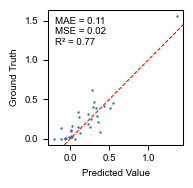

In [ ]:
set_seed(421)
# 电导率MLP模型
conductivity_train_losses_mlp, conductivity_val_losses_mlp, conductivity_test_pred_mlp, conductivity_test_true_mlp, conductivity_test_mse_mlp, conductivity_test_mae_mlp, conductivity_test_r2_mlp = train_epochs_mlp(
    0, epochs, model_conductivity_MLP, conductivity_train_loader, conductivity_val_loader, conductivity_test_loader, "conductivity_MLP_model.pt", input_type="fp"
)

plot_targets(conductivity_test_pred_mlp, conductivity_test_true_mlp, conductivity_test_mse_mlp, conductivity_test_mae_mlp, save_path="conductivity_MLP_test.png")

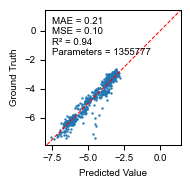

In [ ]:
plot_targets(cation_test_pred, cation_test_true, cation_gat_mse, cation_gat_mae, save_path="cation_GAT_val_LUMO.png")